See the convergence for the number of training episodes

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import pandas as pd
import pickle #allows to serialize and deserialize Python objects.
from mpl_toolkits.mplot3d import Axes3D
from tqdm import trange,tqdm #allows to create progress bars
import os

#change the paths to the correct paths on your computer

directory_path_epis = r"C:\Users\Callens.R\Documents\Kms\1MA sem 2\2. DS425 Intelligent decision support methods\Project weemaes_callens\DS425-Blackjack\data\episodes"
# To see the influence of the hyperparameters
directory_path_hyp = r"C:\Users\Callens.R\Documents\Kms\1MA sem 2\2. DS425 Intelligent decision support methods\Project weemaes_callens\DS425-Blackjack\data\hyperparams"
# Influence of the hyperparameters with the correct reward function
directory_path_hypopt = r"C:\Users\Callens.R\Documents\Kms\1MA sem 2\2. DS425 Intelligent decision support methods\Project weemaes_callens\DS425-Blackjack\data\hyperparamsopt"


In this code the data is computed for the hyperparameters

In [45]:
env = gym.make('Blackjack-v1')

In [46]:
# Define the state space
player_sum_space = range(4, 22)  # possible player hand values (4, 5, ..., 20, 21)
dealer_card_space = range(1, 11)  # possible dealer up card values (2, 3, ..., 10, 11)
usable_ace_space = [False, True]  # whether the player has a usable ace

state_space = []
for player_sum in player_sum_space:
    for dealer_card in dealer_card_space:
        for usable_ace in usable_ace_space:
            state_space.append((player_sum, dealer_card, usable_ace))

# This creates an array of length 306, which is the number of possible states in the game of blackjack. 
# Each state is a tuple of the player’s sum, the dealer’s card, and whether the player has a usable ace.

# Define the action space
action_space = [0, 1]  # hit or stick
# Get the size of the state and action spaces
num_states = len(state_space)
num_actions = len(action_space)

Alright, In the following part the optimal reward function is implemented and the optimal hyperparameter set is calculate.

In [48]:
# Define ranges for hyperparameters
# Use the 'best hyperparameters' found above as the center of the ranges
alpha_range = np.arange(0.01, 0.51, 0.1)
gamma_range = np.arange(0.5, 1.1, 0.1)
epsilon_range = np.arange(0.01, 0.51, 0.1)

rewarddraw = 0
rewardwin = 1.2
rewardloss = -0.8

# Initialize arrays to store win rate for each combination of hyperparameters
win_rates = np.zeros((alpha_range.size, gamma_range.size, epsilon_range.size))
num_episodes = 100000

# Training loop
for i, alpha in enumerate(alpha_range):
    for j, gamma in enumerate(gamma_range):
        for k, epsilon in enumerate(epsilon_range):
            
            # Check if a file already exists for this Q-table
            filename = f"{directory_path_hypopt}/episodes{num_episodes}_q_table_alpha{round(alpha,2)}_gamma{round(gamma,2)}_epsilon{round(epsilon,2)}_RD{rewarddraw}_RW{round(rewardwin,1)}_RL{round(rewardloss,1)}.pkl"
            if os.path.exists(filename):
                #print(f"{filename} already exists, loading...")
                with open(filename, 'rb') as f:
                    Q_table = pickle.load(f)
            else:
                # Run training for current hyperparameters
                Q_table = np.zeros((len(state_space), len(action_space)))
                
                for episode in range(num_episodes):
                    state = env.reset()[0]
                    done = False
                    while not done:
                        # Epsilon-greedy action selection
                        if np.random.random() < epsilon:
                            action = np.random.choice(action_space)
                        else:
                            action = np.argmax(Q_table[state_space.index(state)])

                        # Take the action
                        next_state, reward, done, terminal, dic = env.step(action)
                        
                        # Here the optimal reward function is used!
                        if reward == 0:
                            rewardcalc = rewarddraw
                        elif reward == 1:
                            rewardcalc = rewardwin
                        elif reward == -1:
                            rewardcalc = rewardloss

                        # Update Q-value if you busted, necessary because Q_table(next_state) does not exist if you bust
                        if next_state not in state_space:
                            Q_table[state_space.index(state)][action] += alpha * (rewardcalc - Q_table[state_space.index(state)][action])
                            break

                        # Update Q-value for current state-action pair
                        Q_table[state_space.index(state)][action] += alpha * (rewardcalc + gamma * np.max(Q_table[state_space.index(next_state)]) - Q_table[state_space.index(state)][action])

                        state = next_state  
                # Save the Q-table to a file using pickle
                with open(filename, 'wb') as f:
                    pickle.dump(Q_table, f)

            # See if there is already a file with the winrates
            filename = f"{directory_path_hypopt}/episodes{num_episodes}_winrate_alpha{round(alpha,2)}_gamma{round(gamma,2)}_epsilon{round(epsilon,2)}_RD{rewarddraw}_RW{round(rewardwin,1)}_RL{round(rewardloss,1)}.pkl"
            if os.path.exists(filename):
                #print(f"{filename} already exists, loading...")
                with open(filename, 'rb') as f:
                    win_rate = pickle.load(f)
            else:
                # Evaluate the performance of the Q-table by playing num_games games
                num_wins = 0
                num_losses = 0
                num_draws = 0
                num_games = 100000
                # Initialize arrays to store win rate for each combination of hyperparameters
                win_rates = np.zeros((alpha_range.size, gamma_range.size, epsilon_range.size))

                for n in range(num_games):
                    state = env.reset()[0]
                    done = False
                    while not done:
                        action = np.argmax(Q_table[state_space.index(state)])
                        next_state, reward, done, terminal, dic = env.step(action)
                        state = next_state
                        if done and reward == 1:
                            num_wins += 1
                        elif done and reward == -1:
                            num_losses += 1
                        elif done and reward == 0:
                            num_draws += 1

                win_rate = num_wins / (num_games - num_draws)
                filename = f"{directory_path_hypopt}/episodes{num_episodes}_winrate_alpha{round(alpha,2)}_gamma{round(gamma,2)}_epsilon{round(epsilon,2)}_RD{rewarddraw}_RW{round(rewardwin,1)}_RL{round(rewardloss,1)}.pkl"
                with open(filename, 'wb') as f:
                    pickle.dump(win_rate, f)
            win_rates[i, j, k] = win_rate

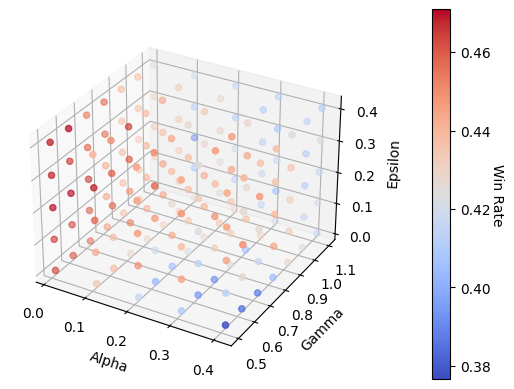

In [49]:
# Visualize results
alpha_grid, gamma_grid, epsilon_grid = np.meshgrid(alpha_range, gamma_range, epsilon_range, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(alpha_grid, gamma_grid, epsilon_grid, c=win_rates.flatten(), cmap='coolwarm')
ax.set_xlabel('Alpha')
ax.set_ylabel('Gamma')
ax.set_zlabel('Epsilon')

# Add colorbar
cbar = fig.colorbar(sc, pad = 0.15)
cbar.ax.set_ylabel('Win Rate', rotation=270, labelpad=10)

plt.show()

In [51]:
# Find indices of maximum win rate
max_idx = np.unravel_index(np.argmax(win_rates), win_rates.shape)

# Extract corresponding hyperparameters
best_alpha = alpha_range[max_idx[0]]
best_gamma = gamma_range[max_idx[1]]
best_epsilon = epsilon_range[max_idx[2]]

# Print best hyperparameters and corresponding win rate
print("Best hyperparameters:")
print(f"Alpha: {best_alpha}")
print(f"Gamma: {best_gamma}")
print(f"Epsilon: {best_epsilon}")
print(f"Win rate: {win_rates[max_idx]}")

Best hyperparameters:
Alpha: 0.01
Gamma: 0.6
Epsilon: 0.21000000000000002
Win rate: 0.47091609907798776


Now we know these results we can do a more in depth analysis
Be aware that alpha can't be too low because then the convergence rate will be to low

In [53]:
# Define ranges for hyperparameters
# Use the 'best hyperparameters' found above as the center of the ranges
alpha_range = np.arange(0.01, 0.1, 0.01)
gamma_range = np.arange(0.3, 0.7, 0.05)
epsilon_range = np.arange(0.1, 0.3, 0.05)

rewarddraw = 0
rewardwin = 1.2
rewardloss = -0.8

# Initialize arrays to store win rate for each combination of hyperparameters
win_rates = np.zeros((alpha_range.size, gamma_range.size, epsilon_range.size))
num_episodes = 100000

# Training loop
for i, alpha in enumerate(alpha_range):
    for j, gamma in enumerate(gamma_range):
        for k, epsilon in enumerate(epsilon_range):
            
            # Check if a file already exists for this Q-table
            filename = f"{directory_path_hypopt}/episodes{num_episodes}_q_table_alpha{round(alpha,2)}_gamma{round(gamma,2)}_epsilon{round(epsilon,2)}_RD{rewarddraw}_RW{round(rewardwin,1)}_RL{round(rewardloss,1)}.pkl"
            if os.path.exists(filename):
                #print(f"{filename} already exists, loading...")
                with open(filename, 'rb') as f:
                    Q_table = pickle.load(f)
            else:
                # Run training for current hyperparameters
                Q_table = np.zeros((len(state_space), len(action_space)))
                
                for episode in range(num_episodes):
                    state = env.reset()[0]
                    done = False
                    while not done:
                        # Epsilon-greedy action selection
                        if np.random.random() < epsilon:
                            action = np.random.choice(action_space)
                        else:
                            action = np.argmax(Q_table[state_space.index(state)])

                        # Take the action
                        next_state, reward, done, terminal, dic = env.step(action)
                        
                        # Here the optimal reward function is used!
                        if reward == 0:
                            rewardcalc = rewarddraw
                        elif reward == 1:
                            rewardcalc = rewardwin
                        elif reward == -1:
                            rewardcalc = rewardloss

                        # Update Q-value if you busted, necessary because Q_table(next_state) does not exist if you bust
                        if next_state not in state_space:
                            Q_table[state_space.index(state)][action] += alpha * (rewardcalc - Q_table[state_space.index(state)][action])
                            break

                        # Update Q-value for current state-action pair
                        Q_table[state_space.index(state)][action] += alpha * (rewardcalc + gamma * np.max(Q_table[state_space.index(next_state)]) - Q_table[state_space.index(state)][action])

                        state = next_state  
                # Save the Q-table to a file using pickle
                with open(filename, 'wb') as f:
                    pickle.dump(Q_table, f)

            # See if there is already a file with the winrates
            filename = f"{directory_path_hypopt}/episodes{num_episodes}_winrate_alpha{round(alpha,2)}_gamma{round(gamma,2)}_epsilon{round(epsilon,2)}_RD{rewarddraw}_RW{round(rewardwin,1)}_RL{round(rewardloss,1)}.pkl"
            if os.path.exists(filename):
                #print(f"{filename} already exists, loading...")
                with open(filename, 'rb') as f:
                    win_rate = pickle.load(f)
            else:
                # Evaluate the performance of the Q-table by playing num_games games
                num_wins = 0
                num_losses = 0
                num_draws = 0
                num_games = 100000
                # Initialize arrays to store win rate for each combination of hyperparameters
                win_rates = np.zeros((alpha_range.size, gamma_range.size, epsilon_range.size))

                for n in range(num_games):
                    state = env.reset()[0]
                    done = False
                    while not done:
                        action = np.argmax(Q_table[state_space.index(state)])
                        next_state, reward, done, terminal, dic = env.step(action)
                        state = next_state
                        if done and reward == 1:
                            num_wins += 1
                        elif done and reward == -1:
                            num_losses += 1
                        elif done and reward == 0:
                            num_draws += 1

                win_rate = num_wins / (num_games - num_draws)
                filename = f"{directory_path_hypopt}/episodes{num_episodes}_winrate_alpha{round(alpha,2)}_gamma{round(gamma,2)}_epsilon{round(epsilon,2)}_RD{rewarddraw}_RW{round(rewardwin,1)}_RL{round(rewardloss,1)}.pkl"
                with open(filename, 'wb') as f:
                    pickle.dump(win_rate, f)
            win_rates[i, j, k] = win_rate

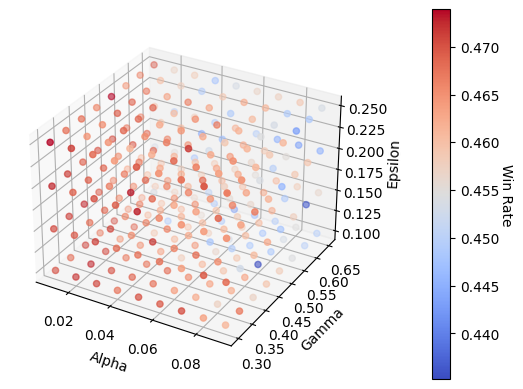

In [54]:
# Visualize results Using grid plot
alpha_grid, gamma_grid, epsilon_grid = np.meshgrid(alpha_range, gamma_range, epsilon_range, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(alpha_grid, gamma_grid, epsilon_grid, c=win_rates.flatten(), cmap='coolwarm')
ax.set_xlabel('Alpha')
ax.set_ylabel('Gamma')
ax.set_zlabel('Epsilon')

# Add colorbar
cbar = fig.colorbar(sc, pad = 0.15)
cbar.ax.set_ylabel('Win Rate', rotation=270, labelpad=10)

plt.show()

In [55]:
# Find indices of maximum win rate
max_idx = np.unravel_index(np.argmax(win_rates), win_rates.shape)

# Extract corresponding hyperparameters
best_alpha = alpha_range[max_idx[0]]
best_gamma = gamma_range[max_idx[1]]
best_epsilon = epsilon_range[max_idx[2]]

# Print best hyperparameters and corresponding win rate
print("Best hyperparameters:")
print(f"Alpha: {best_alpha}")
print(f"Gamma: {best_gamma}")
print(f"Epsilon: {best_epsilon}")
print(f"Win rate: {win_rates[max_idx]}")

Best hyperparameters:
Alpha: 0.01
Gamma: 0.49999999999999994
Epsilon: 0.25000000000000006
Win rate: 0.47390559448239505


Chek the convergence with these params

100%|██████████| 100/100 [00:02<00:00, 45.78it/s]


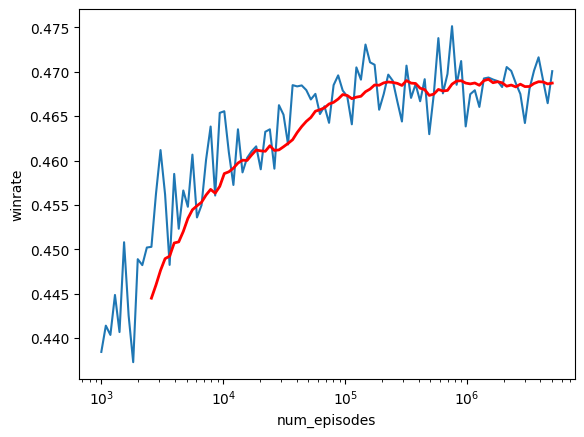

In [ ]:
# Hyperparameters
alpha = 0.01  # Learning rate
gamma = 0.5  # Discount factor
epsilon = 0.25  # Epsilon-greedy parameter
num_games = 100000
num_draws = 0

rewarddraw = 0
rewardwin = 1.2
rewardloss = -0.8

# These are the inputs where the data in the 'data' map can be used for:

start = 1000
stop = 5000000
num = 100  # Adjust the number of values as per your preference
num_episodes_values = np.logspace(np.log10(start), np.log10(stop), num).astype(int)

#start = 1000
#end = 130000
#step = 1000
#num_episodes_values = list(range(start, end, step))


winrates = []
for i in trange(len(num_episodes_values)):
    num_episodes = num_episodes_values[i]

    # Check if a file already exists for this Q-table
    filename = f"{directory_path_epis}/episodes{num_episodes}_q_table_alpha{alpha}_gamma{gamma}_epsilon{epsilon}.pkl"
    if os.path.exists(filename):
        #print(f"{filename} already exists, loading...")
        with open(filename, 'rb') as f:
            Q_table = pickle.load(f)
    else:
        Q_table = np.zeros((len(state_space), len(action_space)))
        for episode in range(num_episodes):
            state = env.reset()[0]
            done = False
            while not done:
                        # Epsilon-greedy action selection
                        if np.random.random() < epsilon:
                            action = np.random.choice(action_space)
                        else:
                            action = np.argmax(Q_table[state_space.index(state)])

                        # Take the action
                        next_state, reward, done, terminal, dic = env.step(action)
                        
                        # Here the optimal reward function is used!
                        if reward == 0:
                            rewardcalc = rewarddraw
                        elif reward == 1:
                            rewardcalc = rewardwin
                        elif reward == -1:
                            rewardcalc = rewardloss

                        # Update Q-value if you busted, necessary because Q_table(next_state) does not exist if you bust
                        if next_state not in state_space:
                            Q_table[state_space.index(state)][action] += alpha * (rewardcalc - Q_table[state_space.index(state)][action])
                            break

                        # Update Q-value for current state-action pair
                        Q_table[state_space.index(state)][action] += alpha * (rewardcalc + gamma * np.max(Q_table[state_space.index(next_state)]) - Q_table[state_space.index(state)][action])

                        state = next_state
            with open(filename, 'wb') as f:
                pickle.dump(Q_table, f)
# See if there is already a file with the winrates
    filename = f"{directory_path_epis}/episodes{num_episodes}_winrate_alpha{round(alpha,2)}_gamma{round(gamma,2)}_epsilon{round(epsilon,2)}_RD{rewarddraw}_RW{round(rewardwin,1)}_RL{round(rewardloss,1)}.pkl"
    if os.path.exists(filename):
        #print(f"{filename} already exists, loading...")
        with open(filename, 'rb') as f:
            win_rate = pickle.load(f)
    else:
        # Evaluate the performance of the Q-table by playing num_games games
        num_wins = 0
        num_losses = 0
        num_draws = 0
        num_games = 100000
        # Initialize arrays to store win rate for each combination of hyperparameters
        for n in range(num_games):
            state = env.reset()[0]
            done = False
            while not done:
                action = np.argmax(Q_table[state_space.index(state)])
                next_state, reward, done, terminal, dic = env.step(action)
                state = next_state
                if done and reward == 1:
                    num_wins += 1
                elif done and reward == -1:
                    num_losses += 1
                elif done and reward == 0:
                    num_draws += 1

        win_rate = num_wins / (num_games - num_draws)
        filename = f"{directory_path_epis}/episodes{num_episodes}_winrate_alpha{round(alpha,2)}_gamma{round(gamma,2)}_epsilon{round(epsilon,2)}_RD{rewarddraw}_RW{round(rewardwin,1)}_RL{round(rewardloss,1)}.pkl"
        with open(filename, 'wb') as f:
            pickle.dump(win_rate, f)
    
    winrates.append(win_rate)

# Calculate the average winrate over adjacent points
window_size = 12
average_winrates = np.convolve(winrates, np.ones(window_size), 'valid') / window_size

# Calculate the corresponding num_episodes values for the average winrates
average_num_episodes = num_episodes_values[(window_size - 1):]

# Plot winrate vs num_episodes
plt.plot(num_episodes_values, winrates)
plt.plot(average_num_episodes, average_winrates, 'r-', linewidth=2)  # Add the average line
plt.xscale('log')
plt.xlabel('num_episodes')
plt.ylabel('winrate')
plt.show()